In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Mental rotation

In this notebook we will show how we can enable a pretrained Generative Query Network (GQN) for the Shepard-Metzler mental rotation task. The problem is well studied in psychology to asses spatial intelligence. Mental rotation is a congitive hard problem as it typically requires the employment of both the ventral and dorsal visual streams for recognition and spatial reasoning respectively. Additionally, a certain degree of metacognition is required to reason about uncertainty.

It turns out that the GQN is capable of this, as we will see in this notebook.

<div class="alert alert-block alert-danger">
<strong>Note:</strong>
This model has only been trained on around 10% of the data for $2 \times 10^5$ iterations instead of the $2 \times 10^6$ described in the original paper. This means that the reconstructions are quite bad and the samples are even worse. Consequently, this notebook is just a proof of concept that the model approximately works. If you have the computational means to fully train the model, then please feel free to make a pull request with the trained model, this will help me a lot.
</div>

You can download the pretrained model weights from here: [https://github.com/wohlert/generative-query-network-pytorch/releases/tag/0.1](https://github.com/wohlert/generative-query-network-pytorch/releases/download/0.1/model-checkpoint.pth).

In [2]:
import torch
import torch.nn as nn
    
# Load dataset
from shepardmetzler import ShepardMetzler
from torch.utils.data import DataLoader

dataset = ShepardMetzler("data/shepard_metzler_5_parts/") ## <= Choose your data location
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [3]:
from gqn import GenerativeQueryNetwork, partition

# Load model parameters onto CPU
state_dict = torch.load("./model-checkpoint.pth", map_location="cpu") ## <= Choose your model location

# Initialise new model with the settings of the trained one
model_settings = dict(x_dim=3, v_dim=7, r_dim=256, h_dim=128, z_dim=64, L=8)
model = GenerativeQueryNetwork(**model_settings)

# Load trained parameters, un-dataparallel if needed
if True in ["module" in m for m in list(state_dict.keys())]:
    model = nn.DataParallel(model)
    model.load_state_dict(state_dict)
    model = model.module
else:
    model.load_state_dict(state_dict)
    
model

GenerativeQueryNetwork(
  (generator): GeneratorNetwork(
    (inference_core): Conv2dLSTMCell(
      (forget): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 394, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (generator_core): Conv2dLSTMCell(
      (forget): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 327, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (posterio

We load a batch of a single image containing a single object seen from 15 different viewpoints. We describe the whole set of image, viewpoint pairs by $\{x_i, v_i \}_{i=1}^{n}$. Whereafter we seperate this set into a context set $\{x_i, v_i \}_{i=1}^{m}$ of $m$ random elements and a query set $\{x^q, v^q \}$, which contains just a single element.

In [4]:
def deterministic_partition(images, viewpoints, indices):
    """
    Partition batch into context and query sets.
    :param images
    :param viewpoints
    :return: context images, context viewpoint, query image, query viewpoint
    """
    # Maximum number of context points to use
    _, b, m, *x_dims = images.shape
    _, b, m, *v_dims = viewpoints.shape

    # "Squeeze" the batch dimension
    images = images.view((-1, m, *x_dims))
    viewpoints = viewpoints.view((-1, m, *v_dims))

    # Partition into context and query sets
    context_idx, query_idx = indices[:-1], indices[-1]

    x, v = images[:, context_idx], viewpoints[:, context_idx]
    x_q, v_q = images[:, query_idx], viewpoints[:, query_idx]

    return x, v, x_q, v_q

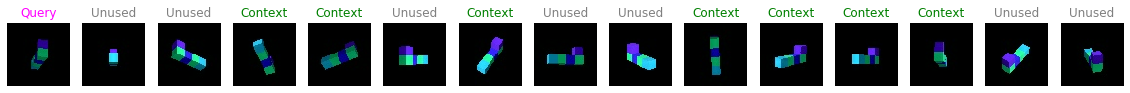

In [5]:
import random

# Pick a scene to visualise
scene_id = 0

# Load data
x, v = next(iter(loader))
x_, v_ = x.squeeze(0), v.squeeze(0)

# Sample a set of views
n_context = 7 + 1
indices = random.sample([i for i in range(v_.size(1))], n_context)

# Seperate into context and query sets
x_c, v_c, x_q, v_q = deterministic_partition(x, v, indices)

# Visualise context and query images
f, axarr = plt.subplots(1, 15, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    # Move channel dimension to end
    ax.imshow(x_[scene_id][i].permute(1, 2, 0))
    
    if i == indices[-1]:
        ax.set_title("Query", color="magenta")
    elif i in indices[:-1]:
        ax.set_title("Context", color="green")
    else:
        ax.set_title("Unused", color="grey")
    
    ax.axis("off")

## Reconstruction

Now we feed the whole set into the network and the network will perform the segregration of sets. The query image is then reconstructed in accordance to a given viewpoint and a representation vector that has been generated only by the context set.

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))

x_mu, r, kl = model(x_c[scene_id].unsqueeze(0), 
                    v_c[scene_id].unsqueeze(0), 
                    x_q[scene_id].unsqueeze(0),
                    v_q[scene_id].unsqueeze(0))

x_mu = x_mu.squeeze(0)
r = r.squeeze(0)

ax1.imshow(x_q[scene_id].data.permute(1, 2, 0))
ax1.set_title("Query image")
ax1.axis("off")

ax2.imshow(x_mu.data.permute(1, 2, 0))
ax2.set_title("Reconstruction")
ax2.axis("off")

ax3.imshow(r.data.view(16, 16))
ax3.set_title("Representation")
ax3.axis("off")

plt.show()

## Visualising representation

We might be interested in visualising the representation as more context points are introduced. The representation network $\phi(x_i, v_i)$ generates a single representation for a context point $(x_i, v_i)$ which is then aggregated (summed) for each context point to generate the final representation.

Below, we see how adding more context points creates a less sparse representation.

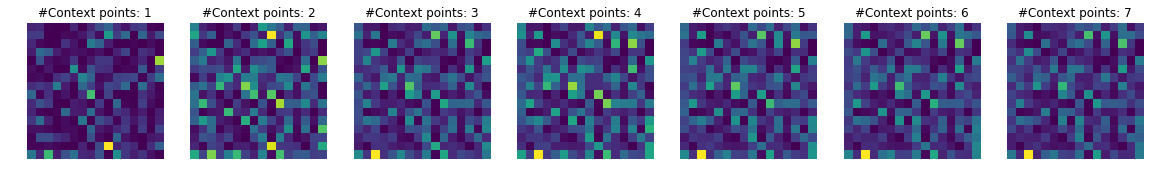

In [188]:
f, axarr = plt.subplots(1, 7, figsize=(20, 7))

r = torch.zeros(128, 256, 1, 1)

from PIL import Image
for i, ax in enumerate(axarr.flat):
    phi = model.representation(x_c[:, i], v_c[:, i])
    r += phi
    ax.imshow(r[scene_id].data.view(16, 16))
    im = Image.fromarray(A)
    im.save("your_file.jpeg")
    ax.axis("off")
    ax.set_title("#Context points: {}".format(i+1))

## Sample from the prior.

Because we use a conditional prior density $\pi(z|y)$ that is parametrised by a neural network, we should be able to continuously refine it during training such that if $y = (v, r)$ we can generate a sample from the data distrbution by sampling $z \sim \pi(z|v,r)$ and sending it through the generative model $g_{\theta}(x|z, y)$.

This means that we can give a number of context points along with a query viewpoint and generate a new image.

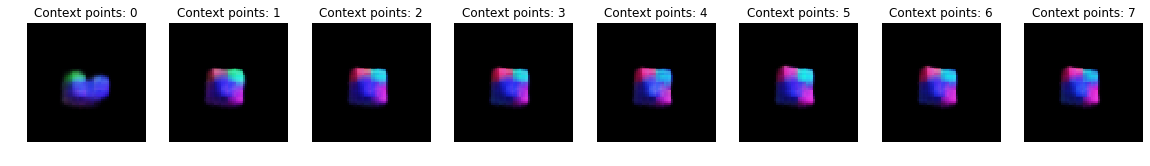

In [189]:
# Create progressively growing context set
batch_size, n_views, c, h, w = x_c.shape

f, axarr = plt.subplots(1, num_samples, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    x_ = x_c[scene_id][:i+1].view(-1, c, h, w)
    v_ = v_c[scene_id][:i+1].view(-1, 7)
    
    phi = model.representation(x_, v_)
    
    r = torch.sum(phi, dim=0)
    x_mu = model.generator.sample((h, w), v_q[scene_id].unsqueeze(0), r)
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title("Context points: {}".format(i))
    ax.axis("off")

## Mental rotation task

As an extension to the above mentioned sampling procedure, we can perform the mental rotation task by continuously sampling from the prior given a static representation $r$ and then varying the query viewpoint vector $v^q$ between each sample to "rotate the object".

In the example below we change the yaw slightly at each frame for 8 frames.

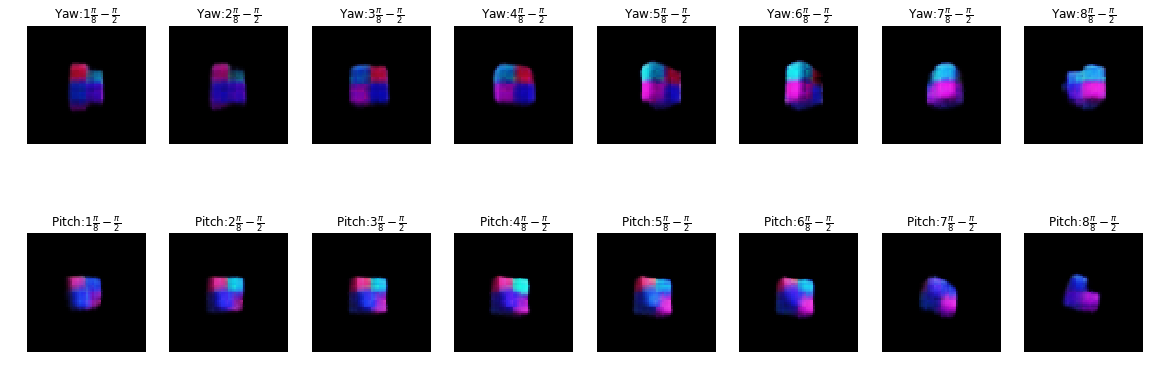

In [198]:
# Change viewpoint yaw
batch_size, n_views, c, h, w = context_x.shape
pi = 3.1415629

x_ = x_c[scene_id].view(-1, c, h, w)
v_ = v_c[scene_id].view(-1, 7)

phi = model.representation(x_, v_)

r = torch.sum(phi, dim=0)

f, axarr = plt.subplots(2, num_samples, figsize=(20, 7))
for i, ax in enumerate(axarr[0].flat):
    v = torch.zeros(7).copy_(v_q[scene_id])
    
    yaw = (i+1) * (pi/8) - pi/2
    v[3], v[4] = np.cos(yaw), np.sin(yaw)

    x_mu = model.generator.sample((h, w), v.unsqueeze(0), r)
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title(r"Yaw:" + str(i+1) + r"$\frac{\pi}{8} - \frac{\pi}{2}$")
    ax.axis("off")
    
for i, ax in enumerate(axarr[1].flat):
    v = torch.zeros(7).copy_(v_q[scene_id])
    
    pitch = (i+1) * (pi/8) - pi/2
    v[5], v[6] = np.cos(pitch), np.sin(pitch)

    x_mu = model.generator.sample((h, w), v.unsqueeze(0), r)
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title(r"Pitch:" + str(i+1) + r"$\frac{\pi}{8} - \frac{\pi}{2}$")
    ax.axis("off")